# Typology for doubles

1. Identify 2-artifact clusters (pairs of contiguous artifacts); make sure that the union has no interior
2. For each cluster, classify the inside edge as C or nonC (`drop_interline`: bool)
3. Visualize and test if it works

- number of nodes
- number of continuity groups
- filter non-planarity artifacts
- CES counts
- prime detection
- crosses detection
- touches detecion

In [1]:
import logging

import geopandas as gpd
import matplotlib.pyplot as plt
import momepy
import numpy as np
import pandas as pd
import shapely
from libpysal import graph
from scipy import sparse
import folium
import folium.plugins as plugins
import shapely

from core import algorithms, utils
from core.geometry import voronoi_skeleton, remove_false_nodes

In [2]:
# Get the logger for core.algorithms.simplify
logger = logging.getLogger("core.algorithms.simplify")
logger.setLevel(logging.DEBUG)

# Set the logging format
formatter = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")

# Create a handler for the logger
handler = logging.StreamHandler()
handler.setLevel(logging.DEBUG)
handler.setFormatter(formatter)

# Add the handler to the logger
logger.addHandler(handler)

Specify case metadata

In [3]:
case = "Liège"

Read road data

In [4]:
roads = utils.read_original(case)

Remove duplicated roads

In [5]:
roads = momepy.remove_false_nodes(roads)
roads = roads[~roads.geometry.duplicated()].reset_index()
roads = momepy.remove_false_nodes(roads)

Identify artifacts

In [6]:
artifacts = momepy.FaceArtifacts(roads).face_artifacts.set_crs(roads.crs)
artifacts["id"] = artifacts.index

Remove edges fully within the artifact (dangles).

In [7]:
a_idx, _ = roads.sindex.query(artifacts.geometry, predicate="contains")
artifacts = artifacts.drop(artifacts.index[a_idx])

Filter doubles

In [8]:
rook = graph.Graph.build_contiguity(artifacts, rook=True)
artifacts["comp"] = rook.component_labels
counts = artifacts["comp"].value_counts()
artifacts = artifacts.loc[artifacts["comp"].isin(counts[counts == 2].index)]

Optionally define a subset of data.

In [9]:
def get_type(edges, shared_edge):
    if (  # roundabout special case
        edges.coins_group.nunique() == 1 and edges.shape[0] == edges.coins_count.iloc[0]
    ):
        return "S"

    all_ends = edges[edges.coins_end]
    mains = edges[~edges.coins_group.isin(all_ends.coins_group)]
    shared = edges.loc[shared_edge]
    if shared_edge in mains.index:
        return "C"
    if shared.coins_count == (edges.coins_group == shared.coins_group).sum():
        return "S"
    return "E"


def get_solution(group, roads):
    cluster_geom = group.union_all(method="coverage")

    # find the road segment that is contained within the cluster geometry
    shared = roads.index[roads.sindex.query(cluster_geom, predicate="contains")].item()
    seen_by_a = get_type(
        roads.iloc[roads.sindex.query(group.geometry.iloc[0], predicate="covers")],
        shared,
    )
    seen_by_b = get_type(
        roads.iloc[roads.sindex.query(group.geometry.iloc[1], predicate="covers")],
        shared,
    )
    if seen_by_a == "C":
        return pd.Series({"solution": "iterate", "drop_id": shared})
    if seen_by_a == seen_by_b:
        return pd.Series({"solution": "drop_interline", "drop_id": shared})
    return pd.Series({"solution": "skeleton", "drop_id": shared})

In [10]:
distance = 2

In [11]:
data_sample = artifacts.sort_values("comp").iloc[:60].copy()
# artifacts = data_sample[data_sample.comp == 27]

In [13]:
def simplify_pairs(artifacts, roads, distance=2):
    # Get nodes from the network.
    nodes = momepy.nx_to_gdf(momepy.node_degree(momepy.gdf_to_nx(roads)), lines=False)

    # Link nodes to artifacts
    node_idx, artifact_idx = artifacts.sindex.query(
        nodes.buffer(0.1), predicate="intersects"
    )
    intersects = sparse.coo_array(
        ([True] * len(node_idx), (node_idx, artifact_idx)),
        shape=(len(nodes), len(artifacts)),
        dtype=np.bool_,
    )

    # Compute number of nodes per artifact
    artifacts["node_count"] = intersects.sum(axis=0)

    # Compute number of stroke groups per artifact
    roads, _ = algorithms.common.continuity(roads)
    strokes, c_, e_, s_ = algorithms.common.get_stroke_info(artifacts, roads)

    artifacts["stroke_count"] = strokes
    artifacts["C"] = c_
    artifacts["E"] = e_
    artifacts["S"] = s_

    # Filer artifacts caused by non-planar intersections.
    artifacts["non_planar"] = artifacts["stroke_count"] > artifacts["node_count"]
    a_idx, _ = roads.sindex.query(artifacts.geometry.boundary, predicate="overlaps")
    artifacts.loc[artifacts.index[np.unique(a_idx)], "non_planar"] = True

    # Remove (for now) the clusters that contain at least one non-planar component
    # (TODO: we will deal with them later, ...?)
    # non_planar_cluster: number of non-planar artifacts per cluster
    artifacts["non_planar_cluster"] = artifacts.apply(
        lambda x: sum(artifacts.loc[artifacts["comp"] == x.comp]["non_planar"]), axis=1
    )
    np_clusters = artifacts[artifacts.non_planar_cluster > 0]
    artifacts = artifacts[artifacts.non_planar_cluster == 0]

    artifacts = artifacts.merge(
        artifacts.groupby("comp").apply(get_solution, roads=roads),
        left_on="comp",
        right_index=True,
    )

    to_drop = (
        artifacts.drop_duplicates("comp").query("solution == 'drop_interline'").drop_id
    )
    merged_pairs = artifacts.query("solution == 'drop_interline'").dissolve(
        "comp", as_index=False
    )

    sorted_by_node_count = artifacts.sort_values("node_count", ascending=False)
    first = sorted_by_node_count.query("solution == 'iterate'").drop_duplicates("comp", keep="first")
    second = sorted_by_node_count.query("solution == 'iterate'").drop_duplicates("comp", keep="last")

    first = pd.concat([first, np_clusters[~np_clusters.non_planar]], ignore_index=True)

    roads_cleaned = remove_false_nodes(
        roads.drop(to_drop.dropna().values),
        aggfunc={
            "coins_group": "first",
            "coins_end": lambda x: x.any(),
        },
    )
    coins_count = roads_cleaned.groupby("coins_group", as_index=False).geometry.count().rename(columns={"geometry": "coins_count"})
    roads_cleaned = roads_cleaned.merge(coins_count, on="coins_group", how="left")

    loop_1 = algorithms.simplify.simplify_singletons(
        pd.concat([merged_pairs, first]),
        roads_cleaned,
        distance=distance,
        compute_coins=False,
    )
    loop_2 = algorithms.simplify.simplify_singletons(
        second, loop_1, distance=distance, compute_coins=True
    )

    # TODO: include resolving of `solution == 'skeleton'`
    return loop_2

/var/folders/2f/fhks6w_d0k556plcv3rfmshw0000gn/T/ipykernel_97243/3830872583.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  artifacts.groupby("comp").apply(get_solution, roads=roads),


In [15]:
new_roads = simplify_pairs(data_sample, roads)

/var/folders/2f/fhks6w_d0k556plcv3rfmshw0000gn/T/ipykernel_93271/2940680198.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  artifacts.groupby("comp").apply(get_solution, roads=roads),
2024-07-29 13:15:13,190 - core.algorithms.simplify - DEBUG - FUNCTION nx_gx
2024-07-29 13:15:13,191 - core.algorithms.simplify - DEBUG - HIGHEST C
2024-07-29 13:15:13,197 - core.algorithms.simplify - DEBUG - CONDITION n_comps > 1 True
2024-07-29 13:15:13,201 - core.algorithms.simplify - DEBUG - CONDITION relevant_targets.shape[0] > 0 False, snapping to C
2024-07-29 13:15:13,202 - core.algorithms.simplify - DEBUG - CONDITION remaining_nodes.shape[0] < 2 False
/Users/martin/miniforge3/envs/simplification/lib/pyth

Pandas(Index=0, comp=3, geometry=<POLYGON ((685359.515 5609771.28, 685361.781 5609776.114, 685363.671 5609778...>, face_artifact_index=7.000196621280116, id=10, node_count=5, stroke_count=5, C=1, E=2, S=2, non_planar=False, non_planar_cluster=0, solution='drop_interline', drop_id=24105.0, interstitial_nodes=0, ces_type='5CEESS', buffered=<POLYGON ((685359.515 5609771.28, 685359.515 5609771.28, 685359.515 5609771....>)
Pandas(Index=1, comp=6, geometry=<POLYGON ((679838.132 5612658.057, 679823.814 5612660.281, 679813.416 561266...>, face_artifact_index=5.477688988071806, id=19, node_count=2, stroke_count=2, C=1, E=0, S=1, non_planar=False, non_planar_cluster=0, solution='drop_interline', drop_id=15969.0, interstitial_nodes=0, ces_type='2CS', buffered=<POLYGON ((679831.552 5612681.072, 679832.754 5612680.891, 679832.754 561268...>)
Pandas(Index=2, comp=22, geometry=<POLYGON ((665604.574 5608501.989, 665529.053 5608542.45, 665530.469 5608544...>, face_artifact_index=5.875322831400373, id=1

/Users/martin/miniforge3/envs/simplification/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
2024-07-29 13:15:13,398 - core.algorithms.simplify - DEBUG - FUNCTION n1_g1_identical
/Users/martin/miniforge3/envs/simplification/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
2024-07-29 13:15:13,410 - core.algorithms.simplify - DEBUG - FUNCTION nx_gx
2024-07-29 13:15:13,411 - core.algorithms.simplify - DEBUG - HIGHEST C
2024-07-29 13:15:13,413 - core.algorithms.simplify - DEBUG - CONDITION n_comps > 1 True
2024-07-29 13:15:13,417 - core.algorithms.simplify - DEBUG - CONDITION len(highest_hierarchy) > 1 True
2024-07-29 13:15:13,418 - core.algorithms.simplify - DEBUG - CONDITION for CCSS special case False
/Users/martin/miniforge3/envs/simplification/lib/python3.11/site-pa

Pandas(Index=7, comp=46, geometry=<POLYGON ((669758.608 5619415.381, 669725.721 5619426.021, 669731.394 561944...>, face_artifact_index=5.678091866516539, id=1201, node_count=1, stroke_count=1, C=0, E=1, S=0, non_planar=False, non_planar_cluster=0, solution='drop_interline', drop_id=1270.0, interstitial_nodes=0, ces_type='1E', buffered=<POLYGON ((669758.608 5619415.381, 669758.608 5619415.381, 669758.608 561941...>)
Pandas(Index=8, comp=48, geometry=<POLYGON ((685589.895 5616685.765, 685593.906 5616670.613, 685560.173 561666...>, face_artifact_index=6.184953829981916, id=4200, node_count=5, stroke_count=3, C=1, E=1, S=1, non_planar=False, non_planar_cluster=0, solution='drop_interline', drop_id=7073.0, interstitial_nodes=2, ces_type='5CES', buffered=<POLYGON ((685589.895 5616685.765, 685593.906 5616670.613, 685593.906 561667...>)
Pandas(Index=9, comp=56, geometry=<POLYGON ((680370.686 5604861.94, 680369.989 5604860.958, 680359.947 5604878...>, face_artifact_index=5.635718637144363, id=

2024-07-29 13:15:13,603 - core.algorithms.simplify - DEBUG - CONDITION relevant_targets.shape[0] > 0 False, snapping to C
2024-07-29 13:15:13,603 - core.algorithms.simplify - DEBUG - CONDITION remaining_nodes.shape[0] < 2 True
/Users/martin/miniforge3/envs/simplification/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
2024-07-29 13:15:13,604 - core.algorithms.simplify - DEBUG - CONDITION is_within False
/Users/martin/miniforge3/envs/simplification/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
2024-07-29 13:15:13,625 - core.algorithms.simplify - DEBUG - FUNCTION nx_gx
2024-07-29 13:15:13,626 - core.algorithms.simplify - DEBUG - HIGHEST C
2024-07-29 13:15:13,628 - core.algorithms.simplify - DEBUG - DROP ONLY
2024-07-29 13:15:13,629 - core.algorithms.simplify - DEBUG

Pandas(Index=0, comp=4, geometry=<POLYGON ((682082.999 5609910.253, 682075.805 5609894.91, 682062.643 5609900...>, face_artifact_index=5.472529911617042, id=11, node_count=4, stroke_count=4, C=3, E=1, S=0, non_planar=False, non_planar_cluster=0, solution='iterate', drop_id=7362.0, interstitial_nodes=0, ces_type='4CCCE', buffered=<POLYGON ((682082.999 5609910.253, 682082.999 5609910.253, 682082.999 560991...>)
Pandas(Index=1, comp=161, geometry=<POLYGON ((684284.673 5619429.978, 684274.934 5619424.069, 684276.438 561943...>, face_artifact_index=3.7421916312669, id=1029, node_count=4, stroke_count=4, C=1, E=2, S=1, non_planar=False, non_planar_cluster=0, solution='iterate', drop_id=22565.0, interstitial_nodes=0, ces_type='4CEES', buffered=<POLYGON ((684284.673 5619429.978, 684284.673 5619429.978, 684284.673 561942...>)
Pandas(Index=2, comp=27, geometry=<POLYGON ((677852.095 5610780.27, 677877.61 5610791.22, 677864.916 5610776.1...>, face_artifact_index=4.6857860305786865, id=1849, node_c

/Users/martin/Git/simplification/core/algorithms/simplify.py:819: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'True' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  artifacts.iloc[np.unique(a_idx), -1] = True
2024-07-29 13:15:23,246 - core.algorithms.simplify - DEBUG - FUNCTION nx_gx_identical
2024-07-29 13:15:23,251 - core.algorithms.simplify - DEBUG - FUNCTION nx_gx
2024-07-29 13:15:23,252 - core.algorithms.simplify - DEBUG - HIGHEST C
2024-07-29 13:15:23,254 - core.algorithms.simplify - DEBUG - CONDITION n_comps > 1 True
2024-07-29 13:15:23,258 - core.algorithms.simplify - DEBUG - CONDITION len(highest_hierarchy) > 1 True
2024-07-29 13:15:23,259 - core.algorithms.simplify - DEBUG - CONDITION for CCSS special case False
/Users/martin/miniforge3/envs/simplification/lib/python3.11/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encounte

Pandas(Index=6295, geometry=<POLYGON ((684284.673 5619429.978, 684283.889 5619434.381, 684284.436 561943...>, face_artifact_index=6.2092065829218654, id=6295, comp=161, node_count=3, stroke_count=1, C=1, E=0, S=0, non_planar=False, non_planar_cluster=0, solution='iterate', drop_id=True, interstitial_nodes=2, ces_type='3C', buffered=<POLYGON ((684284.673 5619429.978, 684284.673 5619429.978, 684284.673 561942...>)
Pandas(Index=3708, geometry=<POLYGON ((682040.339 5609914.827, 682049.104 5609928.355, 682065.886 560991...>, face_artifact_index=5.326187816995691, id=3708, comp=4, node_count=4, stroke_count=4, C=2, E=2, S=0, non_planar=False, non_planar_cluster=0, solution='iterate', drop_id=7362, interstitial_nodes=0, ces_type='4CCEE', buffered=<POLYGON ((682040.339 5609914.827, 682040.339 5609914.827, 682040.339 560991...>)


3


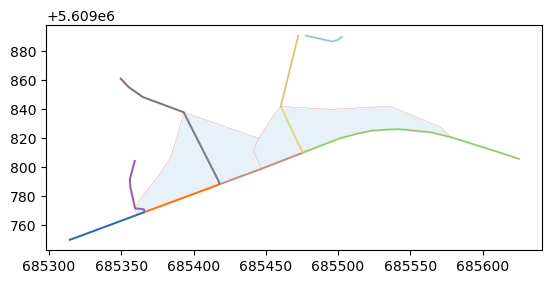

4


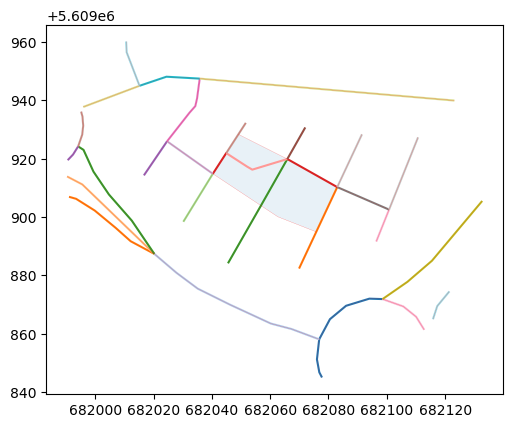

6


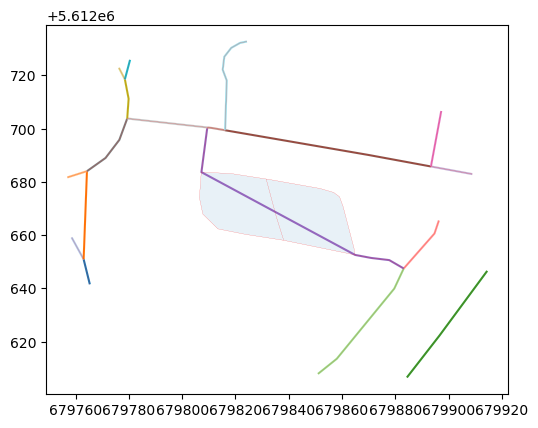

22


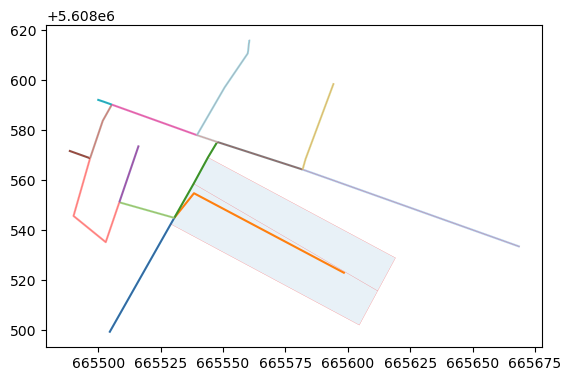

27


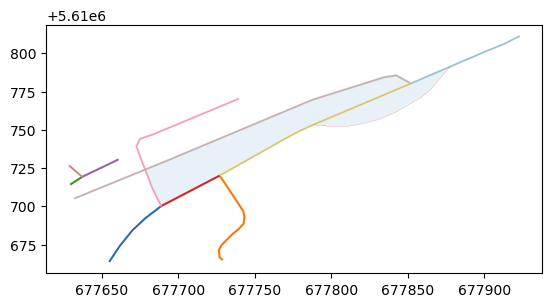

28


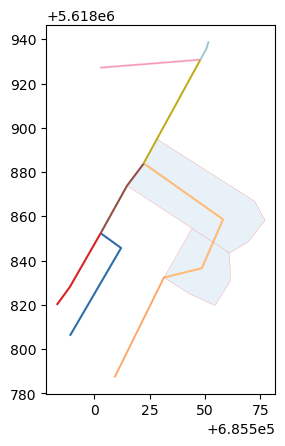

37


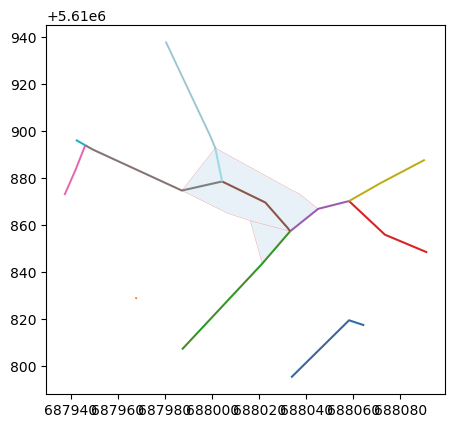

38


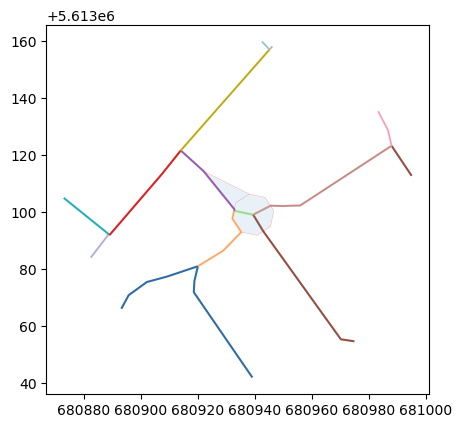

45


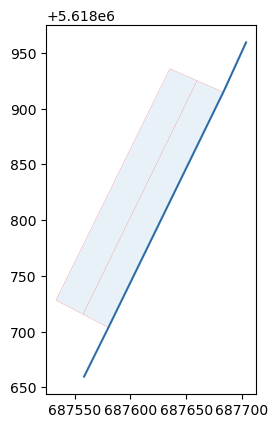

46


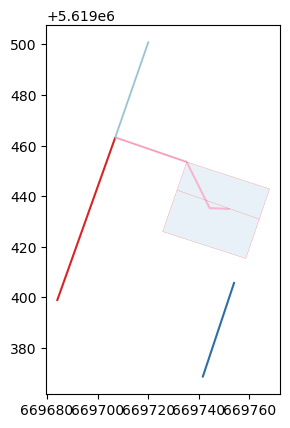

48


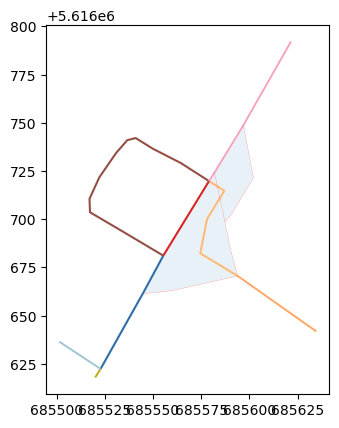

50


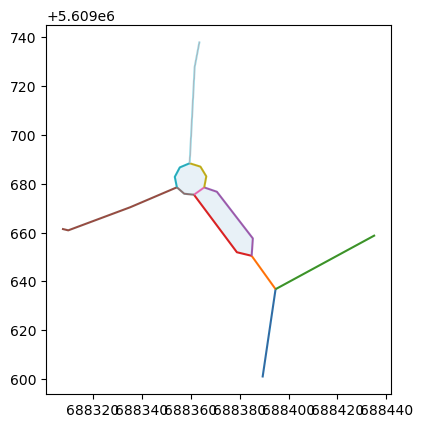

56


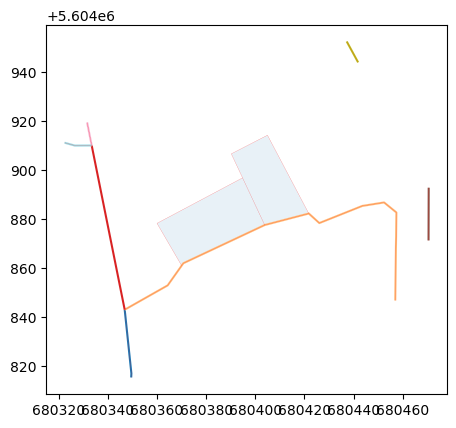

61


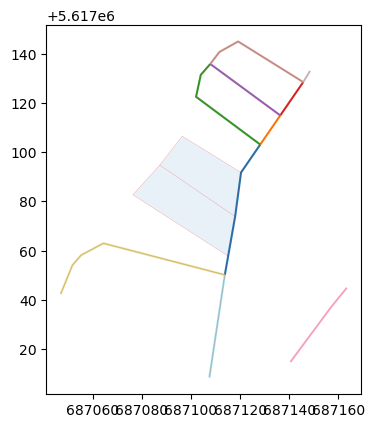

72


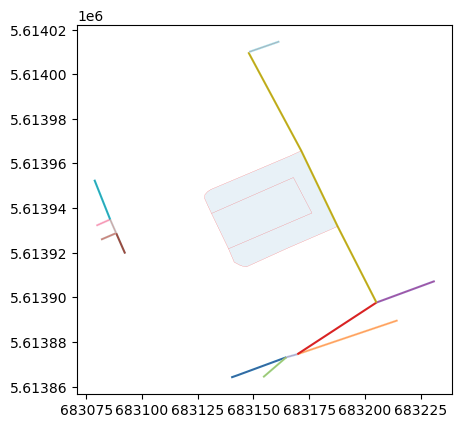

74


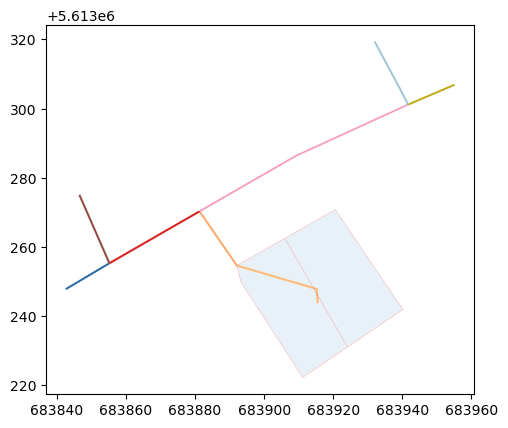

88


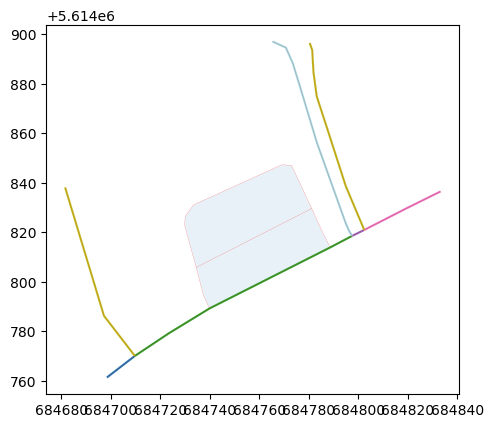

93


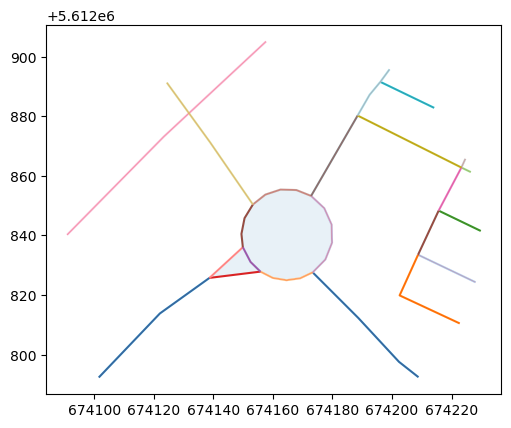

95


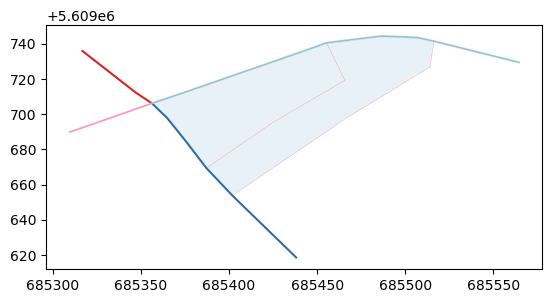

96


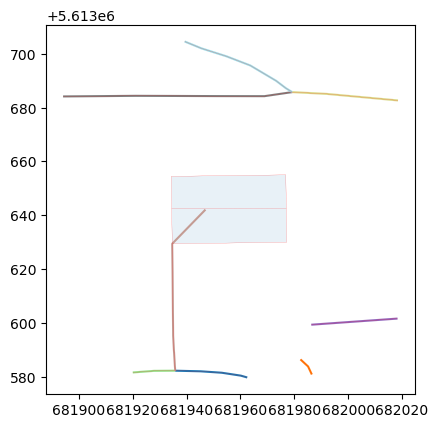

98


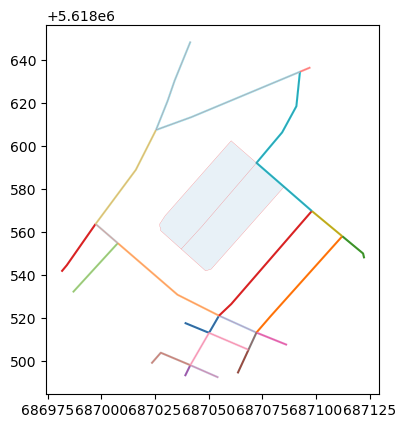

115


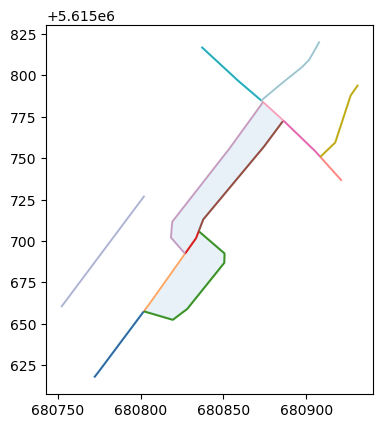

128


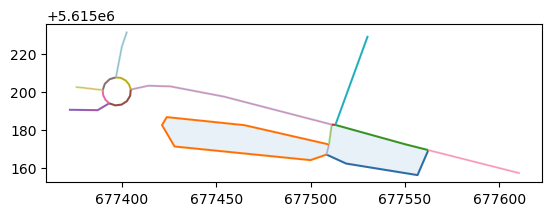

137


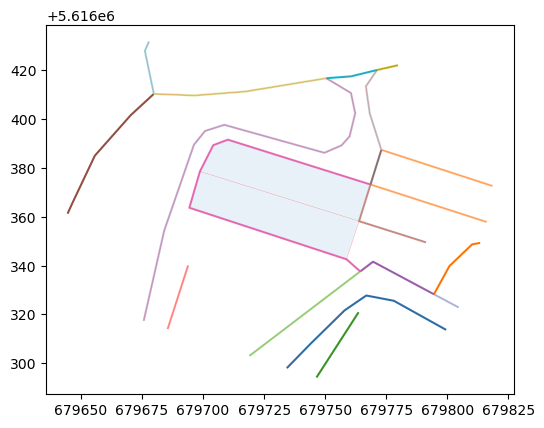

147


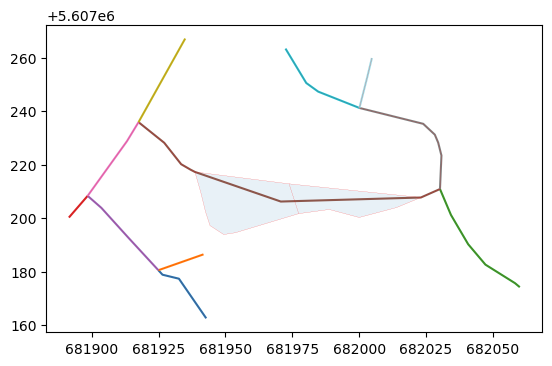

149


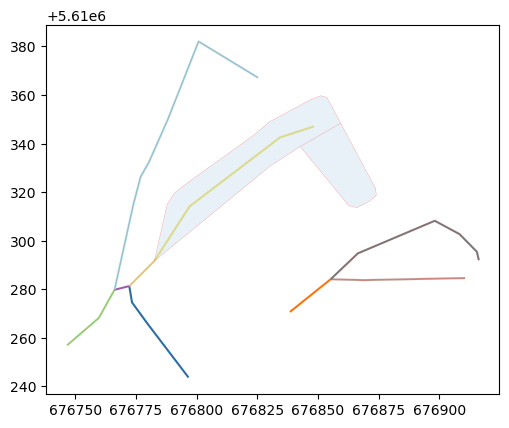

161


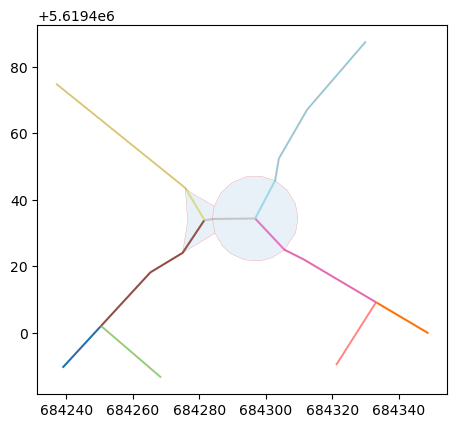

173


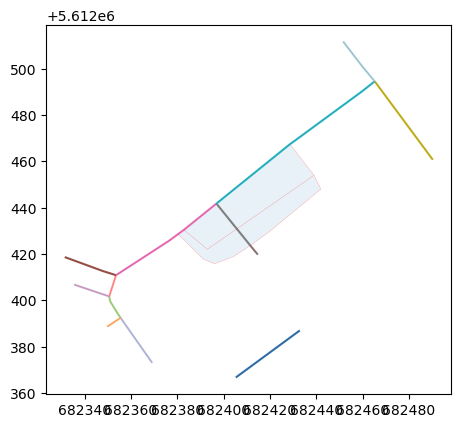

189


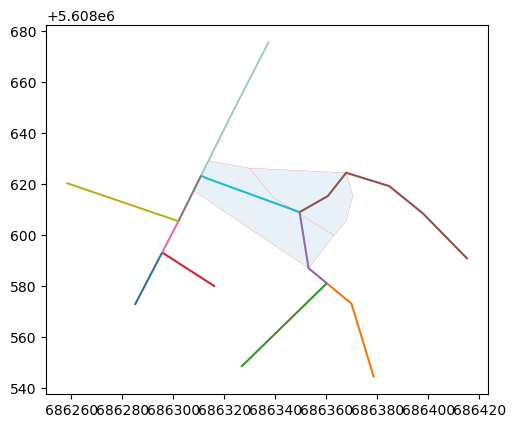

197


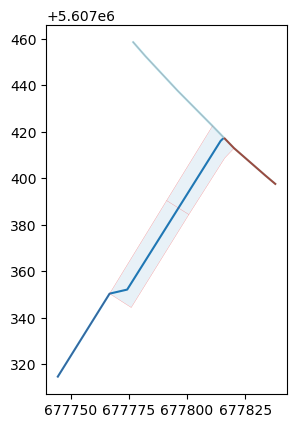

In [16]:
for artifact in data_sample.drop_duplicates("comp").itertuples():
    print(artifact.comp)

    # plot the results for visual verification
    geom = data_sample[data_sample.comp == artifact.comp]
    ax = new_roads.clip(geom.buffer(50)).plot(zorder=2, cmap="tab20")
    geom.plot(ax=ax, alpha=0.1)
    roads.clip(geom.buffer(50)).plot(
        color="red",
        ax=ax,
        # categorical=True,
        # legend=True,
        linewidth=0.1,
    )
    plt.show()